# Equipo 2
## Miembros:
### Jorge Arturo Torres Cruz - A01176590
### Juan Manuel Pérez Font - A00819815

## Recolección de datos

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ==== FOR REFERENCE =====
# ['wines.txt', 'bubble_gums.txt', 'dumplings.txt', 'pizza_urls.txt', 'sandwich.txt']
# =========== ============
url_files = ['wines.txt', 'bubble_gums.txt', 'dumplings.txt', 'pizza.txt', 'sandwich.txt']

# ==== FOR REFERENCE =====
# ['wine','bubble_gum', 'dumplings', 'pizza', 'sandwich']
# ========================
categories = ['wine', 'bubble_gum', 'dumpling', 'pizza', 'sandwich']

data_directory = './drive/My Drive/data' # Where image data and models will be stored

In [0]:
def read_urls_from_txt(files):
  """Reads all urls from the txt files in files

  Args:
      files (list): List of txt files

  Returns:
      array: an array with all urls extracted by category 
  """
  # Iteramos por cada uno de los archivos y obtenemos los URLs de las imagenes.
  print("Reading files containing images urls")
  urls = []
  for file_name in files:
    with open(f'{data_directory}/{file_name}') as f:
      content = f.readlines()
      content = [url.strip() for url in content]
      print(f'Reading {len(content)} image urls ({file_name})')
      urls.append(content)
  return urls

In [0]:
# Utilizaremos urllib para descargar las imagenes utilizando URLs obtenidos de ImageNet
import urllib.request
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import uuid
from itertools import repeat

In [9]:
def download_from_url(category_url):
  """Downloads a single an image from the given url with urllib.

  Args:
      category_url (tuple): A tuple containing a url and its category in the form (category, url)

  Returns:
      str: A string with the url if success, an error string otherwise
  """
  category, url = category_url
  print(f'Downloading {url} for category {category}')
  try:
    urllib.request.urlretrieve(url, f'{data_directory}/{category}/{uuid.uuid4()}.jpg')
    return url
  except Exception as e:
    print('Error')
    return f'Error: {e}'

def download_category_from_url(category, urls):
  """Download images from all urls from a given category

  Args:
      category (str): The category name
      urls (list): A list of urls from the category

  Returns:
      A ThreadPoolExecutor results: The results from the ThreadPoolExecutor
  """
  try:
    print(f'Creating directory to store {category} images')
    os.mkdir(f'{data_directory}/{category}')
  except FileExistsError:
    print(f'{data_directory}/{category} directory exists, continuing...')
  except Exception as e:
    print(e)
  else:
    print(f'Succesfully created {category}/ directory')
  results = None
  with ThreadPoolExecutor(max_workers=8) as executor:
    return executor.map(download_from_url, zip(repeat(category), urls), timeout=0.5)

try:
  os.mkdir(data_directory)
except FileExistsError:
  print('data directory exists, continuing...')

# Download required images. Commented to work out of the box for training.
# urls = read_urls_from_txt(url_files)
# for idx, category in enumerate(categories):
#   download_category_from_url(category, urls[idx])

data directory exists, continuing...
Reading files containing images urls
Reading 723 image urls (wines.txt)
Reading 655 image urls (bubble_gums.txt)
Reading 773 image urls (dumplings.txt)
Reading 856 image urls (pizza.txt)
Reading 722 image urls (sandwich.txt)
Creating directory to store wine images
Succesfully created wine/ directory



Error
Error
Error
Error
Error
Creating directory to store bubble_gum images
Succesfully created bubble_gum/ directory

Creating directory to store dumpling images
Succesfully created dumpling/ directory

Creating directory to store pizza images
Succesfully created pizza/ directory
Error
Error
Creating directory to store sandwich images
Succesfully created sandwich/ directory

Error
Error
Error


## Generación de datos

In [12]:
!pip install imgaug==0.4.0

     |████████████████████████████████| 952kB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
import numpy as np
import imgaug.augmenters as iaa
import cv2
import glob

In [4]:
def augment_data():
  """
  Generates new data based on downloaded images by applying left-to-right flip, Gaussian Blur,
  Salt and Pepper, GammaContrast and Additive gaussian noise with varying probabilities. 
  Each image is augmented twice, resulting in triple the original data.
  """
  print('Augmenting data by flipping and Gaussian Blur...')
  seq = iaa.Sequential([
    iaa.Fliplr(0.65),
    iaa.Sometimes(then_list=[
      iaa.OneOf([
        iaa.GammaContrast(gamma=(0.5, 1.75)),
        iaa.GaussianBlur(sigma=(0, 2.0))
      ])
    ]),
    iaa.Sometimes(p=0.55, then_list=[
      iaa.AdditiveGaussianNoise(scale=0.10*255)
    ]),
    iaa.Sometimes(p=0.3, then_list=[
      iaa.SaltAndPepper(p=0.05)
    ])
  ], random_order=True)
    
  for category in categories:
    batch = []
    for filename in glob.iglob(f'{data_directory}/{category}/*'):
      print(f'Reading {filename}')
      try:
        im = cv2.imread(filename)
        cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        batch.append(im)
        batch.append(im)
      except Exception as e:
        print(f'Error on image: {filename}, continuing...')
    images_aug = seq(images=np.array(batch))
    for image in images_aug:
      cv2.imwrite(f'{data_directory}/{category}/{uuid.uuid4()}.jpg', image)
      print(f'Artificial data saved for category {category}')
    print(f'=== {len(batch)} new images added to category {category} ===')

# Augment data. Commented in order to work out of the box for training.
# augment_data()

Augmenting data by flipping and Gaussian Blur...
Reading ./drive/My Drive/data/wine/b48c140c-7852-40f8-bd31-40065d61f431.jpg
Reading ./drive/My Drive/data/wine/7dfec16e-b121-4509-8d8f-0d01f5f4a6f5.jpg
Reading ./drive/My Drive/data/wine/cd38c968-ae54-4df8-b90a-12177c8e82e8.jpg
Reading ./drive/My Drive/data/wine/9b186076-c74b-4d67-89a6-5e5bcdfecb44.jpg
Reading ./drive/My Drive/data/wine/8c60b400-705d-4145-94e1-2df4f45f84ce.jpg
Reading ./drive/My Drive/data/wine/a9bc3f2d-1c1b-4558-9695-b8fd732ab876.jpg
Reading ./drive/My Drive/data/wine/a9c5f9b7-5ccf-4af4-856e-d3fbd757f33e.jpg
Reading ./drive/My Drive/data/wine/6dc9dbab-5a2f-4bdd-9375-6d0ecd8dacd0.jpg
Reading ./drive/My Drive/data/wine/6ca2468a-af5a-43c5-b161-e4faaef6509b.jpg
Reading ./drive/My Drive/data/wine/b2d796e4-7afc-48bf-b28c-c109524d23ff.jpg
Reading ./drive/My Drive/data/wine/701b1768-97b4-49d9-8bfe-4e982f8980ac.jpg
Error on image: ./drive/My Drive/data/wine/701b1768-97b4-49d9-8bfe-4e982f8980ac.jpg, continuing...
Reading ./drive/

/usr/local/lib/python3.6/dist-packages/imgaug/dtypes.py:354: UserWarning: Got dtype 'object' in augmenter 'UnnamedGammaContrast' (class 'GammaContrast'), which was neither explicitly allowed (uint8, uint16, uint32, uint64, int8, int16, int32, int64, float16, float32, float64), nor explicitly disallowed (float96, float128, float256, bool). Generated outputs may contain errors.
  ", ".join(disallowed)


Streaming output truncated to the last 5000 lines.
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for category dumpling
Artificial data saved for

In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3400352937390318396, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12264301011219386467
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 306795509174850807
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3056042273097797216
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

## Separar train, test y validate

In [0]:
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [0]:
try:
  os.mkdir(f'{data_directory}/train')
except FileExistsError as e:
  print('train directory already exists, continuing...')
try:
  os.mkdir(f'{data_directory}/test')
except FileExistsError as e:
  print('test directory already exists, continuing...')
try:
  os.mkdir(f'{data_directory}/valid')
except FileExistsError as e:
  print('validate directory already exists, continuing...')

for category in categories:
  try:
    os.mkdir(f'{data_directory}/train/{category}')
    os.mkdir(f'{data_directory}/valid/{category}')
    os.mkdir(f'{data_directory}/test/{category}')
  except FileExistsError as e:
    print(f'{category} directory already exists, continuing...')

  try:
    images = glob.glob(f'{data_directory}/{category}/*')
    for i in random.sample(images, int(len(images) * 0.8)):
      shutil.move(i, f'{data_directory}/train/{category}/')
    images = glob.glob(f'{data_directory}/{category}/*')
    for i in random.sample(images, int(len(images) * 0.5)):
      shutil.move(i, f'{data_directory}/valid/{category}/')
    images = glob.glob(f'{data_directory}/{category}/*')
    for i in random.sample(images, int(len(images))):
      shutil.move(i, f'{data_directory}/test/{category}/')

    os.rmdir(f'{data_directory}/{category}')
  except FileNotFoundError as e:
    print('Directory already deleted, continuing...')

In [7]:
def clean_images():
  dirs = ['train', 'test', 'valid']
  for d in dirs:
    for category in categories:
      for f in glob.glob(f'{data_directory}/{d}/{category}/*'):
        try:
          im = cv2.imread(f)
          cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
          with open(f, 'rb') as fl:
            check_chars = fl.read()[-2:]
          if check_chars != b'\xff\xd9':
            print('Not complete image')
            os.remove(f)
          else:
            print(f'{f} image ok')
        except Exception as e:
          os.remove(f)
          print(f'{f} image erased')

# Clean images. Commented in order to work out of the box for training.
# clean_images()

Streaming output truncated to the last 5000 lines.
./drive/My Drive/data/train/pizza/859b8cb0-6a8b-40f2-86b1-c87a21b21ed2.jpg image ok
./drive/My Drive/data/train/pizza/7b03a187-f189-492e-a932-10c19ee09280.jpg image ok
./drive/My Drive/data/train/pizza/bc057f69-553c-4217-b525-97512e01bf90.jpg image ok
./drive/My Drive/data/train/pizza/91a8574a-64b0-4a1f-8d3f-fc329a41886f.jpg image ok
./drive/My Drive/data/train/pizza/a3990a05-fafd-49b4-a45f-25ba0e00a95e.jpg image ok
./drive/My Drive/data/train/pizza/bd85b90c-6305-415b-8679-0d3c8801b5ad.jpg image ok
./drive/My Drive/data/train/pizza/68350f62-4de8-4bdd-b1a0-5b92376b22ff.jpg image ok
./drive/My Drive/data/train/pizza/6fc22608-3f19-4bb3-b81c-bd209749d1f7.jpg image ok
./drive/My Drive/data/train/pizza/d394092e-efa7-41f6-8fb1-82247fc8f20a.jpg image ok
./drive/My Drive/data/train/pizza/8753eb70-511e-43bb-acfe-802e236795dc.jpg image ok
./drive/My Drive/data/train/pizza/770fec27-d9c1-48c3-bfca-619cacf806c0.jpg image ok
./drive/My Drive/data/tra

## Entrenamiento

In [0]:
train_data = f'{data_directory}/train'
test_data = f'{data_directory}/test'
valid_data = f'{data_directory}/valid'

batch_size = 10

In [22]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=train_data, target_size=(224,224), classes=['wine', 'pizza', 'bubble_gum', 'dumpling', 'sandwich'], batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=test_data, target_size=(224,224), classes=['wine', 'pizza', 'bubble_gum', 'dumpling', 'sandwich'], batch_size=batch_size, shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
  .flow_from_directory(directory=valid_data, target_size=(224,224), classes=['wine', 'pizza', 'bubble_gum', 'dumpling', 'sandwich'], batch_size=batch_size)

Found 8608 images belonging to 5 classes.
Found 1080 images belonging to 5 classes.
Found 1075 images belonging to 5 classes.


In [0]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

for layer in model.layers:
  layer.trainable = False

model.add(Dense(units=5, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
  x=train_batches,
  validation_data=valid_batches,
  epochs=15,
  verbose=2
)
model.save(f'{data_directory}/fifth_try.h5')

Epoch 1/15
861/861 - 71s - loss: 0.3961 - accuracy: 0.8566 - val_loss: 0.2188 - val_accuracy: 0.9274
Epoch 2/15
861/861 - 72s - loss: 0.1780 - accuracy: 0.9380 - val_loss: 0.1746 - val_accuracy: 0.9377
Epoch 3/15
861/861 - 71s - loss: 0.1328 - accuracy: 0.9563 - val_loss: 0.1584 - val_accuracy: 0.9488
Epoch 4/15
861/861 - 71s - loss: 0.1033 - accuracy: 0.9677 - val_loss: 0.1338 - val_accuracy: 0.9516
Epoch 5/15
861/861 - 71s - loss: 0.0823 - accuracy: 0.9749 - val_loss: 0.1236 - val_accuracy: 0.9572
Epoch 6/15
861/861 - 71s - loss: 0.0663 - accuracy: 0.9818 - val_loss: 0.1210 - val_accuracy: 0.9581
Epoch 7/15
861/861 - 70s - loss: 0.0536 - accuracy: 0.9871 - val_loss: 0.1120 - val_accuracy: 0.9609
Epoch 8/15
861/861 - 69s - loss: 0.0429 - accuracy: 0.9914 - val_loss: 0.1120 - val_accuracy: 0.9609
Epoch 9/15
861/861 - 68s - loss: 0.0353 - accuracy: 0.9929 - val_loss: 0.1047 - val_accuracy: 0.9619
Epoch 10/15
861/861 - 68s - loss: 0.0289 - accuracy: 0.9951 - val_loss: 0.1033 - val_accura

In [0]:
model = load_model(f'{data_directory}/fifth_try.h5')

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
          horizontalalignment="center",
          color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[196   1   2   2   1]
 [  0 249   0   1   5]
 [  1   0 187   1   0]
 [  2   2   4 214   5]
 [  1   0   3   1 202]]


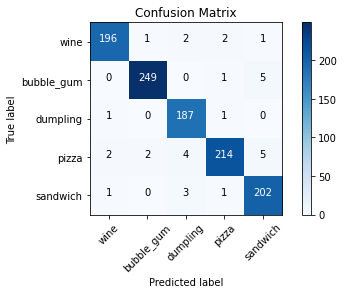

In [27]:
predictions = model.predict(x=test_batches, verbose=0)

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

plot_confusion_matrix(cm=cm, classes=categories, title='Confusion Matrix')